In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating project at `~/Desktop/2024Spring/CMU16745_OptimalControl/CMU16-745-Optimal-Control-HW/hw1`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Glob ─────────── v1.3.1
   Installed CSTParser ────── v3.4.1
   Installed Tokenize ─────── v0.5.28
   Installed CommonMark ───── v0.8.12
   Installed JuliaFormatter ─ v1.0.45
    Updating `~/Desktop/2024Spring/CMU16745_OptimalControl/CMU16-745-Optimal-Control-HW/hw1/Project.toml`
  [98e50ef6] + JuliaFormatter v1.0.45
    Updating `~/Desktop/2024Spring/CMU16745_OptimalControl/CMU16-745-Optimal-Control-HW/hw1/Manifest.toml`
  [00ebfdb7] + CSTParser v3.4.1
  [a80b9123] + CommonMark v0.8.12
  [a8cc5b0e] + Crayons v4.1.1
  [c27321d9] + Glob v1.3.1
  [98e50ef6] + JuliaFormatter v1.0.45
  [0796e94c] + Tokenize v0.5.28
Precompiling project...
  ✓ Glob
  ✓ Tokenize
  ✓ CommonMark
  ✓ CSTParser
  ✓ JuliaFormatter
  5 dependencies successfully precompiled in 19 seconds. 219 already precompi

# Q2 (30 pts): Augmented Lagrangian Quadratic Program Solver

## Part (A): QP Solver (10 pts)
Here we are going to use the augmented lagrangian method described [here in a video](https://www.youtube.com/watch?v=0x0JD5uO_ZQ), with [the corresponding pdf here](https://github.com/Optimal-Control-16-745/lecture-notebooks-2022/blob/main/misc/AL_tutorial.pdf) to solve the following problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\mbox{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \leq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.


By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:

$$\begin{align}
Qx + q + A^T\lambda + G^T \mu &= 0 \quad \quad \text{stationarity}\\ 
Ax-b&= 0 \quad \quad \text{primal feasibility} \\ 
Gx-h&\leq 0 \quad \quad \text{primal feasibility} \\ 
\mu &\geq 0 \quad \quad \text{dual feasibility} \\ 
\mu \circ (Gx - h) &= 0 \quad \quad \text{complementarity}
  \end{align}$$
  where $\circ$ is element-wise multiplication.  

In [18]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following function 
    
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:

as long as solve_qp works. 
"""
function cost(qp::NamedTuple, x::Vector)::Real
    0.5 * x' * qp.Q * x + dot(qp.q, x)
end
function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A * x - qp.b
end
function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G * x - qp.h
end

function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    h_mask = h_ineq(qp, x) .< 0.0
    mu_mask = μ .== 0.0
    Irpo = I(length(μ)) * ρ
    zero_mask = .!(h_mask .* mu_mask)
    return Irpo .* zero_mask
end

function augmented_lagrangian(
    qp::NamedTuple,
    x::Vector,
    λ::Vector,
    μ::Vector,
    ρ::Real,
)::Real
    cost(qp, x) +
    dot(λ, c_eq(qp, x)) +
    dot(μ, h_ineq(qp, x)) +
    0.5 * ρ * c_eq(qp, x)' * c_eq(qp, x) +
    0.5 * h_ineq(qp, x)' * mask_matrix(qp, x, μ, ρ) * h_ineq(qp, x)
end

function logging(
    qp::NamedTuple,
    main_iter::Int,
    AL_gradient::Vector,
    x::Vector,
    λ::Vector,
    μ::Vector,
    ρ::Real,
)
    # TODO: stationarity norm
    stationarity_norm = 0.0 # fill this in 
    @printf(
        "%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
        main_iter,
        stationarity_norm,
        norm(AL_gradient),
        maximum(h_ineq(qp, x)),
        norm(c_eq(qp, x), Inf),
        abs(dot(μ, h_ineq(qp, x))),
        ρ
    )
end
function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    x = zeros(length(qp.q))
    λ = zeros(length(qp.b))
    μ = zeros(length(qp.h))

    if verbose
        @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
        @printf "----------------------------------------------------------------\n"
    end

    # TODO:
    rho = 1.0
    phi = 2.0
    for main_iter = 1:max_iters
        if verbose
            logging(qp, main_iter, zeros(1), x, λ, μ, 0.0)
        end

        # NOTE: when you do your dual update for μ, you should compute
        # your element-wise maximum with `max.(a,b)`, not `max(a,b)`

        # update x
        for inner_iter = 1:max_iters
            L_gradient =
                FD.gradient(_x -> augmented_lagrangian(qp, _x, λ, μ, rho), x)
            L_hessian =
                FD.hessian(_x -> augmented_lagrangian(qp, _x, λ, μ, rho), x)
            x = x - L_hessian \ L_gradient
            if norm(L_gradient) < tol
                break
            end
            if inner_iter == max_iters
                error("x did not converge")
            end
        end

        # update lambda, mu
        λ = λ + rho * c_eq(qp, x)
        μ = max.(0.0, μ + rho * h_ineq(qp, x))

        # update rho
        rho = phi * rho

        # TODO: convergence criteria based on tol   CHECK: if this is the correct way to do it
        kkt_stationary = [qp.Q * x + qp.q + qp.A' * λ + qp.G' * μ]
        kkt_stationary_check = norm(kkt_stationary) < tol
        kkt_primal_eq = c_eq(qp, x)
        kkt_primal_eq_check = norm(kkt_primal_eq) < tol
        kkt_primal_ineq = h_ineq(qp, x)
        kkt_primal_ineq_check = all(kkt_primal_ineq .<= 0.0)
        kkt_complementarity = μ .* h_ineq(qp, x)
        kkt_complementarity_check = norm(kkt_complementarity) < tol
        if kkt_stationary_check &&
           kkt_primal_eq_check &&
           kkt_primal_ineq_check &&
           kkt_complementarity_check
            return x, λ, μ
        end
    end
    error("qp solver did not converge")
end
let
    # example solving qp 
    @load joinpath(@__DIR__, "qp_data.jld2") qp
    x, λ, μ = solve_qp(qp; verbose = true, tol = 1e-8)
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00   4.38e+00   6.49e+00   0.00e+00  0e+00
  2   0.00e+00   0.00e+00   5.51e-01   1.27e+00   4.59e-01  0e+00
  3   0.00e+00   0.00e+00   9.68e-02   6.03e-01   6.58e-02  0e+00
  4   0.00e+00   0.00e+00   7.41e-02   8.78e-02   7.71e-02  0e+00
  5   0.00e+00   0.00e+00   3.92e-03   5.39e-03   2.04e-03  0e+00
  6   0.00e+00   0.00e+00   2.86e-04   5.25e-04   2.36e-04  0e+00
  7   0.00e+00   0.00e+00   1.36e-05   2.70e-05   1.23e-05  0e+00
  8   0.00e+00   0.00e+00   3.55e-07   7.34e-07   3.32e-07  0e+00
  9   0.00e+00   0.00e+00   4.91e-09   1.04e-08   4.68e-09  0e+00
 10   0.00e+00   0.00e+00   3.53e-11   7.61e-11   3.42e-11  0e+00
 11   0.00e+00   0.00e+00   1.31e-13   2.86e-13   1.28e-13  0e+00
 12   0.00e+00   0.00e+00   8.88e-16   8.88e-16   3.26e-16  0e+00
 13   0.00e+00   0.00e+00   9.16e-16   0.00e+00   9.38e-16  0e+00


([-0.3262308057133928, 0.24943797997175304, -0.43226766440523, -1.4172246971242028, -1.3994527400875778, 0.609958240852346, -0.07312202122168282, 1.3031477522000245, 0.5389034791065969, -0.7225813651685227], [-0.12835195123512233, -2.8376241672109543, -0.8320804499649519], [0.0363529426381497, 0.0, 0.0, 1.059444495111564, 0.0])

### QP Solver test

In [19]:
# 10 points 
using Test
@testset "qp solver" begin
    @load joinpath(@__DIR__, "qp_data.jld2") qp
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)

    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(x - qp_solutions.x, Inf) < 1e-3
    @test norm(λ - qp_solutions.λ, Inf) < 1e-3
    @test norm(μ - qp_solutions.μ, Inf) < 1e-3
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   0.00e+00   0.00e+00   4.38e+00   6.49e+00   0.00e+00  0e+00
  2   0.00e+00   0.00e+00   5.51e-01   1.27e+00   4.59e-01  0e+00
  3   0.00e+00   0.00e+00   9.68e-02   6.03e-01   6.58e-02  0e+00
  4   0.00e+00   0.00e+00   7.41e-02   8.78e-02   7.71e-02  0e+00
  5   0.00e+00   0.00e+00   3.92e-03   5.39e-03   2.04e-03  0e+00
  6   0.00e+00   0.00e+00   2.86e-04   5.25e-04   2.36e-04  0e+00
  7   0.00e+00   0.00e+00   1.36e-05   2.70e-05   1.23e-05  0e+00
  8   0.00e+00   0.00e+00   3.55e-07   7.34e-07   3.32e-07  0e+00
  9   0.00e+00   0.00e+00   4.91e-09   1.04e-08   4.68e-09  0e+00
 10   0.00e+00   0.00e+00   3.53e-11   7.61e-11   3.42e-11  0e+00
 11   0.00e+00   0.00e+00   1.31e-13   2.86e-13   1.28e-13  0e+00
 12   0.00e+00   0.00e+00   4.44e-16   6.66e-16   4.70e-16  0e+00
 13   0.00e+00   0.00e+00   4.44e-16   8.88e-16   1.61e-17  0e+00
 14   0.00e+00

Test.DefaultTestSet("qp solver", Any[], 3, false, false, true, 1.706294355379485e9, 1.706294355396911e9, false)

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \mu \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\mu \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \mu_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\mu_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\mu_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (B): QP formulation for Falling Brick (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**PUT ANSWER HERE:**

KKT conditions: 

$$
\begin{align}
    \text{stationarity} & \quad Mv_{k+1} + M(\Delta t \cdot g - v_k) - (J^T \Delta t) \mu_{k+1} = 0 \\
    & ⇒ v_{k+1} = (\frac{1}{M} J^T \mu_{k+1} - g) \Delta t + v_k \\
    \text{primal feasibility} & \quad -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
    \text{dual feasibility} & \quad \mu_{k+1} \geq 0 \\
    \text{complementarity} & \quad \mu_{k+1} \circ (-J(q_k + \Delta t \cdot v_{k+1})) = 0
    
\end{align} 
$$

## Part (C): Brick Simulation (5 pts)

In [77]:
function brick_simulation_qp(q, v; mass=1.0, Δt=0.01)

    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 

    g = [0.0; 9.81]
    J = [0 1.0]

    qp = (
        Q=[mass 0.0; 0.0 mass],
        q=mass * (Δt * g - v),
        A=zeros(0, 2), # don't edit this
        b=zeros(0),   # don't edit this 
        G=-[0.0 Δt],
        h=J * q,
    )

    return qp
end

brick_simulation_qp (generic function with 1 method)

In [78]:
@testset "brick qp" begin

    q = [1, 3.0]
    v = [2, -3.0]

    qp = brick_simulation_qp(q, v)

    # check all the types to make sure they're right
    @show typeof(qp.q)
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}

    @test size(qp.Q) == (2, 2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0, 2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1, 2)
    @test size(qp.h) == (1,)

    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10
    @test norm(qp.G - [0 -0.01]) < 1e-10
    @test abs(qp.h[1] - 3) < 1e-10

end

typeof(qp.q) = Vector{Float64}
Test Summary: | Pass  Total  Time
brick qp      |   10     10  0.0s


Test.DefaultTestSet("brick qp", Any[], 10, false, false, true, 1.706297997387241e9, 1.706297997409736e9, false)

#= In[80]:30 =# @test(abs(maximum(ys) - 2) < 0.1) = Test Passed
#= In[80]:31 =# @test(minimum(ys) > -0.01) = Test Passed
#= In[80]:32 =# @test(abs(xs[end] - 3) < 0.01) = Test Passed
#= In[80]:35 =# @test(maximum(xdot) < 1.0001) = Test Passed
#= In[80]:36 =# @test(minimum(xdot) > 0.9999) = Test Passed
#= In[80]:37 =# @test(ys[110] > 0.01) = Test Passed
#= In[80]:38 =# @test(abs(ys[111]) < 0.01) = Test Passed
#= In[80]:39 =# @test(abs(ys[112]) < 0.01) = Test Passed


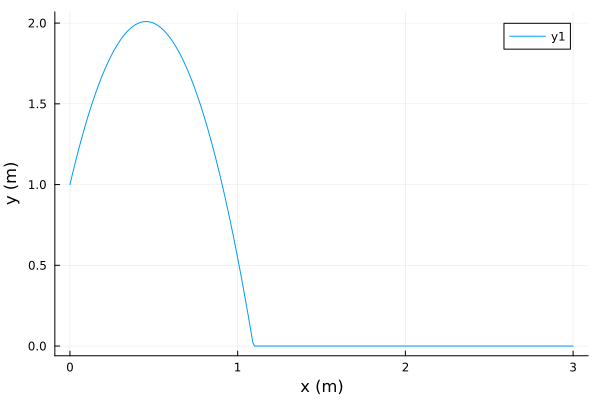

[ Info: Listening on: 127.0.0.1:8701, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8701))

In [80]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let

    dt = 0.01
    T = 3.0

    t_vec = 0:dt:T
    N = length(t_vec)

    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]

    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]

    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    for k = 1:N-1
        qp = brick_simulation_qp(qs[k], vs[k])
        v, λ, μ = solve_qp(qp; verbose = false, max_iters = 100, tol = 1e-6)
        vs[k+1] = v
        qs[k+1] = qs[k] + dt * v
    end


    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]

    @show @test abs(maximum(ys) - 2) < 1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2

    xdot = diff(xs) / dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2

    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))

    animate_brick(qs)



end

# Part D (5 pts): Solve a QP

Use your QP solver to solve the following optimization problem:


$$
\begin{align} 
\min_{y\in\mathbb{R}^2,a\in\mathbb{R},b\in\mathbb{R}} \quad & \frac{1}{2}y^T \begin{bmatrix} 1 & .3 \\ .3 & 1 \end{bmatrix} y + a^2 + 2b^2  + \begin{bmatrix} -2 & 3.4 \end{bmatrix} y + 2a + 4b \\ 
\text{st} \quad & a + b = 1 \\ 
& \begin{bmatrix}-1 & 2.3 \end{bmatrix} y + a - 2b =3 \\
& -0.5 \leq y \leq 1 \\ 
& -1 \leq a \leq 1 \\ 
& -1 \leq b \leq 1
\end{align}
$$

You should be able to put this into our standard QP form that we used above, and solve.

In [82]:
@testset "part D" begin
    # define qp parameters
    qp = (
        Q = [
            1.0 0.3 0.0 0.0
            0.3 1.0 0.0 0.0
            0.0 0.0 1.0 0.0
            0.0 0.0 0.0 2.0
        ],
        q = [-2.0, 3.4, 2.0, 4.0],
        A = [0.0 0.0 1.0 1.0; -1.0 2.3 1.0 -2.0],
        b = [1.0, 3.0],
        G = [
            1.0 0.0 0.0 0.0
            0.0 1.0 0.0 0.0
            -1.0 0.0 0.0 0.0
            0.0 -1.0 0.0 0.0
            0.0 0.0 1.0 0.0
            0.0 0.0 -1.0 0.0
            0.0 0.0 0.0 1.0
            0.0 0.0 0.0 -1.0
        ],
        h = [1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0],
    )

    x, λ, μ = solve_qp(qp; verbose = false, max_iters = 100, tol = 1e-6)

    y = x[1:2]
    a = x[3]
    b = x[4]

    @test norm(y - [-0.080823; 0.834424]) < 1e-3
    @test abs(a - 1) < 1e-3
    @test abs(b) < 1e-3
end

Test Summary: | Pass  Total  Time
part D        |    3      3  0.0s


Test.DefaultTestSet("part D", Any[], 3, false, false, true, 1.706298874341447e9, 1.706298874342658e9, false)

## Part E (5 pts): One sentence short answer

1. For our Augmented Lagrangian solver, if our initial guess for $x$ is feasible (meaning it satisfies the constraints), will it stay feasible through each iteration? 

**put ONE SENTENCE answer here**

A: No. If the initial guess is feasible, the constraint is not active, which implies we are doing unconstrained optimization. Consequently, during the update, the constrains might be violated.

1. Does the Augmented Lagrangian function for this problem always have continuous first derivatives?

**put ONE SENTENCE answer here** 

A: Yes. Otherwise the Newton's method is not applicable since it requires the Hessian. 

1. Is the QP in part D always convex?

**put ONE SENTENCE answer here**

A: Yes. The objective function is convex, and the constraints are affine.